# CELDA DEDICADA A LOS IMPORT 

Todos los import han de estar en esta celda

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SequentialFeatureSelector, mutual_info_classif
import seaborn as sns 
from sklearn.svm import SVC

# DECLARACIÓN DE FUNCIONES

Todas las funciones reusables deben ir a continuación.

In [2]:
def print_classification_report(y, y_pred, y_pred_proba):
    matriz_confusion = confusion_matrix(y,y_pred)
    matriz_confusion_df = pd.DataFrame(matriz_confusion, index=['False','True'], columns=['False','True'])
    print(matriz_confusion_df)
    accuracy= accuracy_score(y, y_pred)
    print(" ")
    print(f"Accuracy: {accuracy}")
    precision = precision_score(y, y_pred)
    print(f"Precision: {precision}")
    recall = recall_score(y, y_pred)
    print(f"Recall: {recall}")
    auc = roc_auc_score(y, y_pred_proba)
    print(f"Area bajo la curva: {auc}")

def barplot(input_df, metric_list):
    # Calcular el número de filas necesarias para las subgráficas (en este caso 3 columnas por fila)
    n_rows = int(np.ceil(len(metric_list) / 3))
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    
    # Aplanar el arreglo de ejes para poder iterar fácilmente
    axes = axes.flatten()
    
    # Crear gráficos de barras por cada columna en metric_list
    for i, col in enumerate(metric_list):
        ax = axes[i]  # Seleccionar el eje correspondiente
        class_counts = input_df[col].value_counts()  # Contar las ocurrencias de cada categoría
        ax.bar(class_counts.index, class_counts.values, color='skyblue')  # Crear gráfico de barras
        ax.set_title(f'Número de Registros por {col}')  # Título del gráfico
        ax.set_xlabel(col)  # Etiqueta del eje X
        ax.set_ylabel('Número de Registros')  # Etiqueta del eje Y
    
    # Eliminar los gráficos sobrantes si hay menos columnas que subgráficas
    for j in range(len(metric_list), len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el diseño para que no se solapen las gráficas
    plt.tight_layout()
    plt.show()


def boxplot_grouping_by_cathegorical(input_df, metric_list,output_variable):
    # Configurar el número de filas y columnas de subplots
    n_rows = int(np.ceil(len(metric_list)/3))
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    
    # Aplanar el arreglo de ejes para iterar fácilmente (si es necesario)
    axes = axes.flatten()
    
    # Crear gráficos de caja por cada columna
    for i, col in enumerate(metric_list):
        ax = axes[i]
        input_df.boxplot(column=[col], by=output_variable, ax=ax, grid=False)
        ax.set_title(f'{col} by Outcome')
        ax.set_xlabel('Outcome')
        ax.set_ylabel(col)
    
    # Quitar gráficos sobrantes si hay menos columnas que subplots
    for j in range(len(metric_list), len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el diseño
    plt.tight_layout()
    plt.show()

def apply_one_hot_encoder(input_df, variable_list):
    # Crear el OneHotEncoder
    encoder = OneHotEncoder(sparse=False)

    # Aplicar OneHotEncoder a las columnas seleccionadas
    encoded_data = encoder.fit_transform(input_df[variable_list])

    # Convertir el resultado a un DataFrame para que sea fácil de manejar
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(variable_list))

    # Concatenar las columnas codificadas al DataFrame original (si es necesario)
    input_encoded_df = pd.concat([input_df.drop(columns=variable_list), encoded_df], axis=1)
    
    return input_encoded_df

def fill_nulls_with_value(input_df, variable_list, value):
    output_df = input_df.copy()
    output_df[variable_list] = output_df[variable_list].fillna(value)
    return output_df

def fill_nulls_with_metric(input_df, variable_list, metric):
    output_df = input_df.copy()
    
    # Diccionario para mapear las métricas a funciones pandas
    metric_functions = {
        'mean': lambda x: x.mean(),
        'median': lambda x: x.median(),
        'max': lambda x: x.max(),
        'min': lambda x: x.min(),
    }

    # Verificar si la métrica proporcionada es válida
    if metric not in metric_functions:
        raise ValueError(f"Métrica '{metric}' no es válida. Usa: {list(metric_functions.keys())}")

    # Iterar sobre las columnas de la lista y rellenar los nulos
    for column in variable_list:
        if column in output_df.columns:
            fill_value = metric_functions[metric](output_df[column])  # Calcular el valor de la métrica
            output_df[column] = output_df[column].fillna(fill_value)  # Rellenar valores nulos
        else:
            print(f"Columna '{column}' no encontrada en el DataFrame.")

    return output_df

def barplot_grouping_by_cathegorical(input_df, metric_list,output_variable):
     # Configurar el número de filas y columnas de subplots
    n_rows = int(np.ceil(len(metric_list)/3))
    n_cols = 3
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    
    # Aplanar el arreglo de ejes para iterar fácilmente (si es necesario)
    axes = axes.flatten()
    
    # Crear gráficos de caja por cada columna
    for i, col in enumerate(metric_list):
        ax = axes[i]
        grouped = input_df.groupby([col, output_variable]).size().unstack(fill_value=0)
        grouped.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')
        ax.set_title(f'{col} by Outcome')
        ax.set_xlabel('Outcome')
        ax.set_ylabel(col)
    
    # Quitar gráficos sobrantes si hay menos columnas que subplots
    for j in range(len(metric_list), len(axes)):
        fig.delaxes(axes[j])
    
    # Ajustar el diseño
    plt.tight_layout()
    plt.show()    

def mdi(X,y):
    rft = RandomForestClassifier(random_state=42)
    rft.fit(X,y)
    mdi_importance = rft.feature_importances_
    
    feature_names = X.columns
    indices = np.argsort(mdi_importance)[::-1]  # Ordenar por importancia
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(mdi_importance)), mdi_importance[indices], align="center", color='skyblue')
    plt.xticks(range(len(mdi_importance)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("MDI Importance")
    plt.title("Feature Importance (MDI) - Random Forest")
    plt.tight_layout()
    plt.show()

def mda(X,y):
    feature_names = X.columns
    rft = RandomForestClassifier(random_state=42)    
    rft.fit(X, y)
    perm_importance = permutation_importance(rft, X, y, scoring="accuracy", n_repeats=10, random_state=42)
    importance_means = perm_importance.importances_mean
    importance_stds = perm_importance.importances_std
    indices = np.argsort(importance_means)[::-1]  # Ordenar por importancia
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance_means)), importance_means[indices], yerr=importance_stds[indices], align="center", color="lightcoral", capsize=5)
    plt.xticks(range(len(importance_means)), [feature_names[i] for i in indices], rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("MDA Importance")
    plt.title("Feature Importance (MDA) - Random Forest")
    plt.tight_layout()
    plt.show()

def plot_histograms(dataset, variables, bins=10):
    n_vars = len(variables)
    n_cols = 3
    n_rows = (n_vars // n_cols) + (n_vars % n_cols > 0)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()
    
    for i, var in enumerate(variables):
        axes[i].hist(dataset[var].dropna(), bins=bins, alpha=0.7, color='blue')
        axes[i].set_title(var)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_mutual_information_heatmap(df, target):
    # Separamos las características (X) y la variable objetivo (y)
    X = df.drop(columns=[target])
    y = df[target]
    
    # Calculamos la información mutua entre las características y la variable objetivo
    mi = mutual_info_classif(X, y)
    
    # Creamos un DataFrame con los resultados
    mi_df = pd.DataFrame(mi, index=X.columns, columns=['Mutual Information'])
    
    # Ordenamos los resultados por la información mutua
    mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)
    
    # Dibujamos el heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(mi_df.T, annot=True, cmap="YlGnBu", cbar=True, fmt='.2f', linewidths=0.5)
    plt.title('Mutual Information between Features and Target')
    plt.show()

def plot_correlation_heatmap(df, method = None):
    if method is None:
        # Calculamos la matriz de correlación entre las variables numéricas
        corr_matrix = df.corr()
    else:
        corr_matrix = df.corr(method = method)
    # Dibujamos el heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5, cbar=True)
    plt.title('Correlación entre las Variables')
    plt.show()

# LECTURA DEL FICHERO

In [3]:
heart_df = pd.read_csv("heart.csv")

# ANÁLISIS DESCRIPTIVO

## INFO Y HEAD

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [5]:
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## DEFINIMOS LAS VARIABLES CATEGÓRICAS/DISCRETAS Y LAS VARIABLES NUMÉRICAS

In [6]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
numerical = [column for column in heart_df.columns if column not in categorical]
print(numerical)

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


## QUÉ REPRESENTA CADA VARIABLE

- age : edad del paciente
- sex : sexo del paciente 1 hombre 0 mujer
- cp : tipo de dolor torácico 0 angina típica, 1 angina atípica, 2 dolor no anginoso, 3 asintomático. Puede ser ordinal.
- trestbps : presión arterial en reposo.
- chol : colesterol cérico
- fbs : nivel de azúcar en sangre, 1 si es mayor que 120 mg/l 0  si es menor.
- restecg : resultado de electrocardiograma en reposo. 0 normal, 1 anormalía en la onda, 2 hipertrofia ventricular izquierda. Puede ser ordinal. 
- thalach : frecuencia cardiaca máxima alcanzada.
- exang : flag de angina inducida por el ejercicio. 
- oldpeak : depresión del st inducida por el ejercicio en relación con el reposo.
- slope : pendiente del segmento st. 0 pendiente pronunciada, 1 pendiente plana, 2 pendiente descendente. Sí es ordinal.
- ca : número de vasos principales coloreados por fluoroscopia de 0 a 3. Es ordinal.
- thal : tipo de talescemia 3 normal, 6 defecto fijo, 7 defecto reversible. No se sabe si es ordinal.
- target : 0 que no tiene enfermedad cardiaca y 1 sí tiene enfermedad cardiaca 

## DESCRIBE DE LAS VARIABLES NUMÉRICAS

In [7]:
heart_df[numerical].describe()

,age,trestbps,chol,thalach,oldpeak
count,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000
mean,54.434146,131.611707,246.00000,149.114146,1.071512
std,9.072290,17.516718,51.59251,23.005724,1.175053
min,29.000000,94.000000,126.00000,71.000000,0.000000
25%,48.000000,120.000000,211.00000,132.000000,0.000000
50%,56.000000,130.000000,240.00000,152.000000,0.800000
75%,61.000000,140.000000,275.00000,166.000000,1.800000
max,77.000000,200.000000,564.00000,202.000000,6.200000


## DISTRIBUCIÓN DE CADA VARIABLE


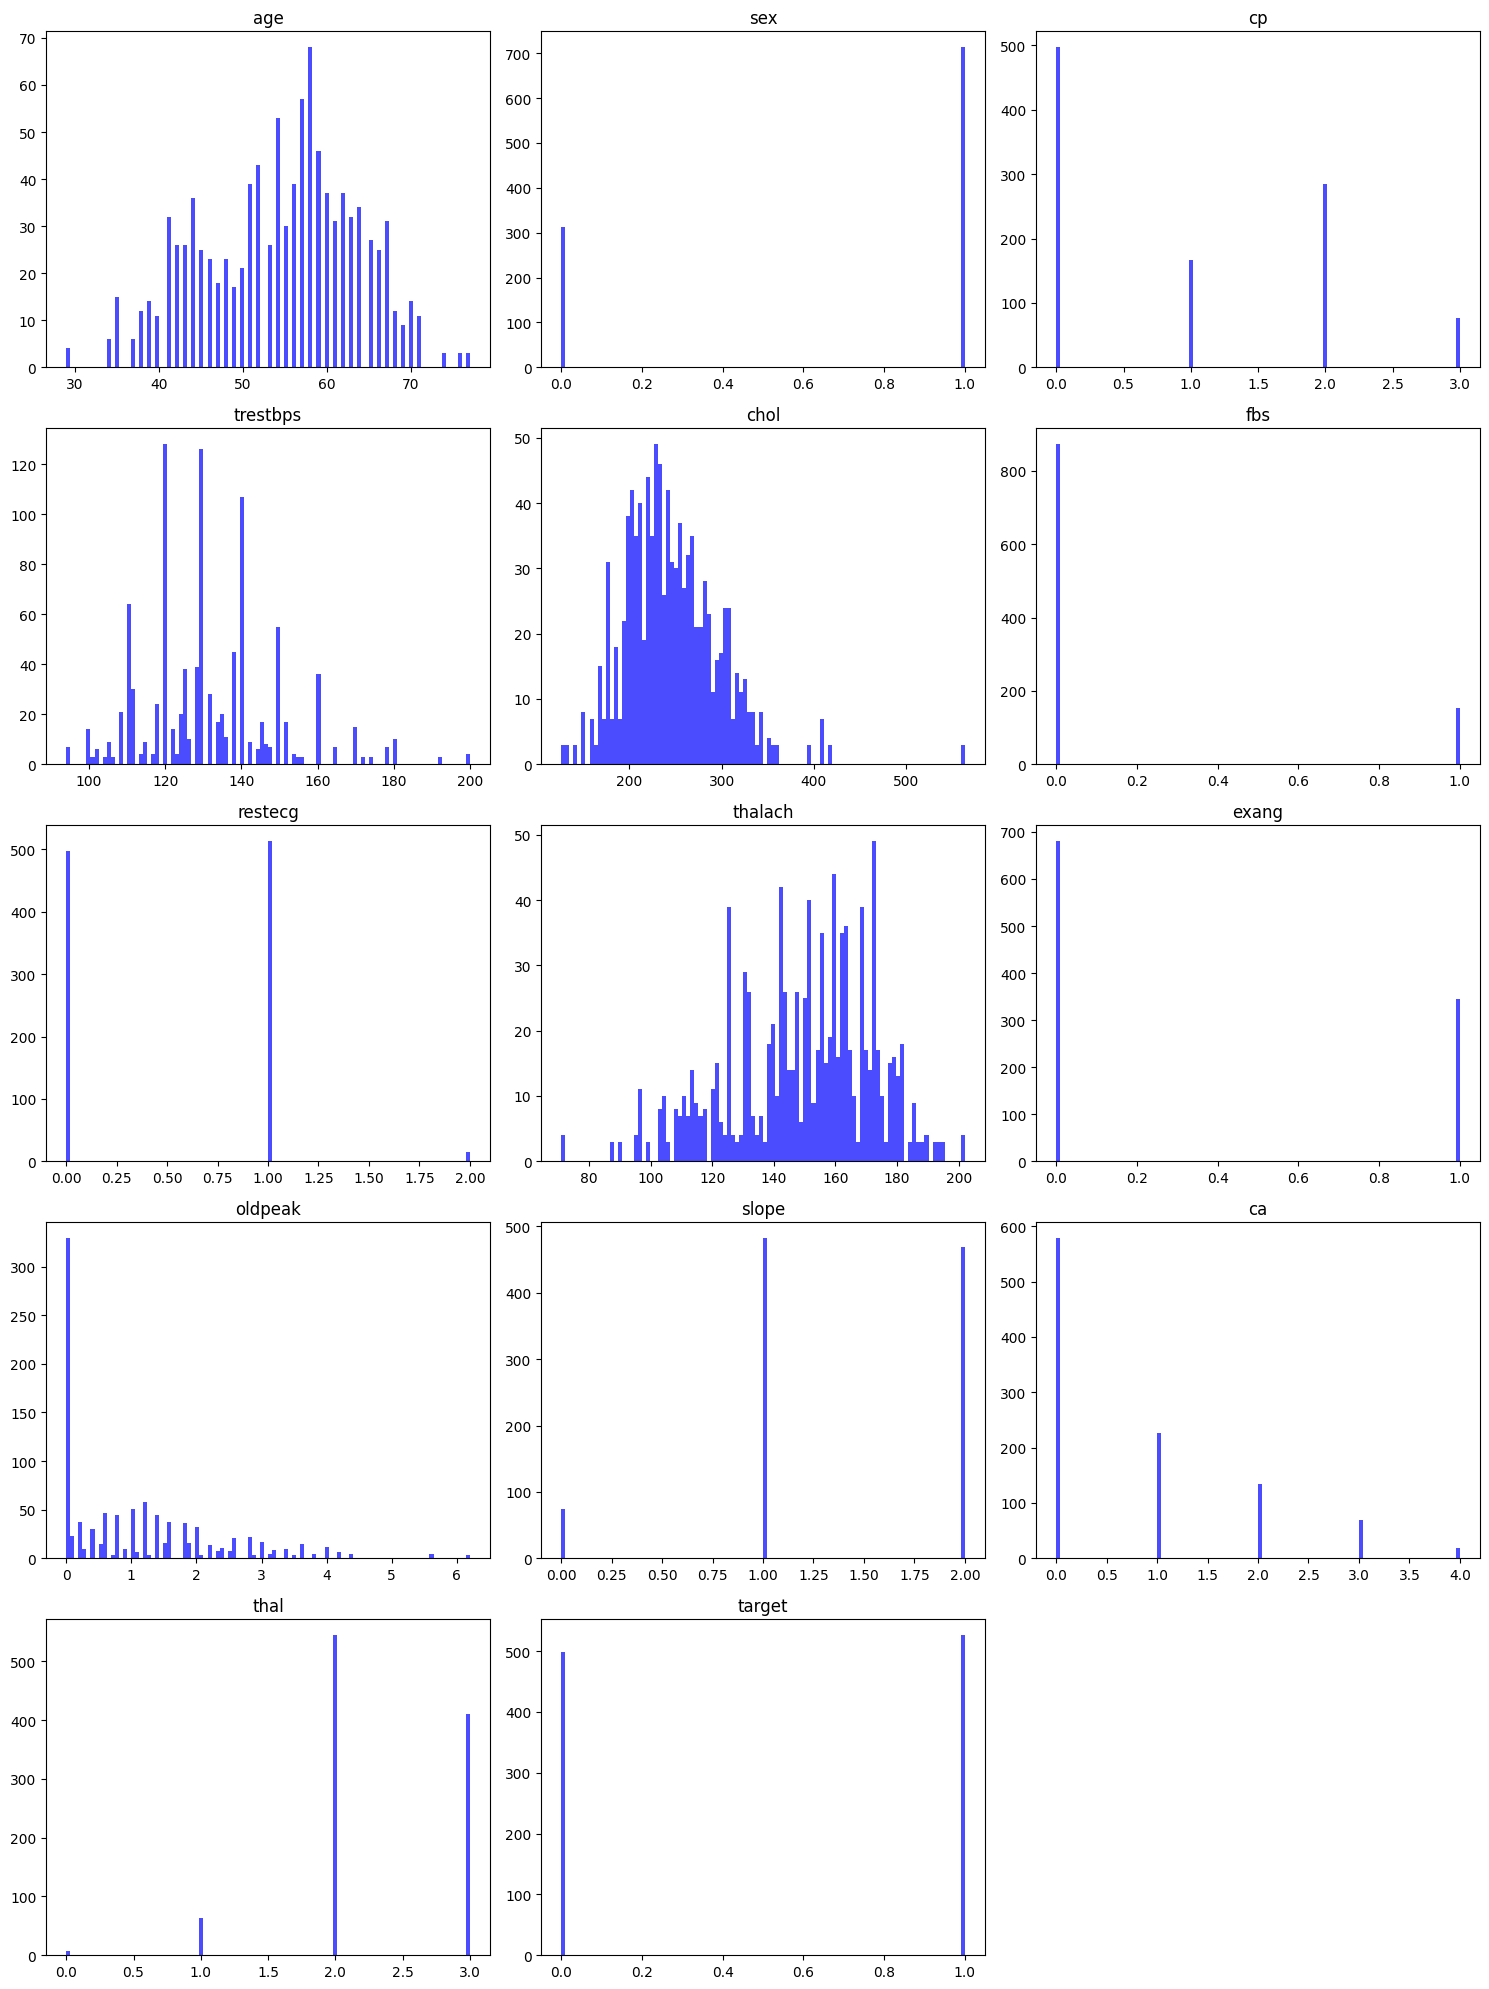

In [8]:
plot_histograms(heart_df,heart_df.columns, 100)

## CORRELACIONES

Boxplot agrupando por target para las continuas y barplot agrupando por target para las discretas

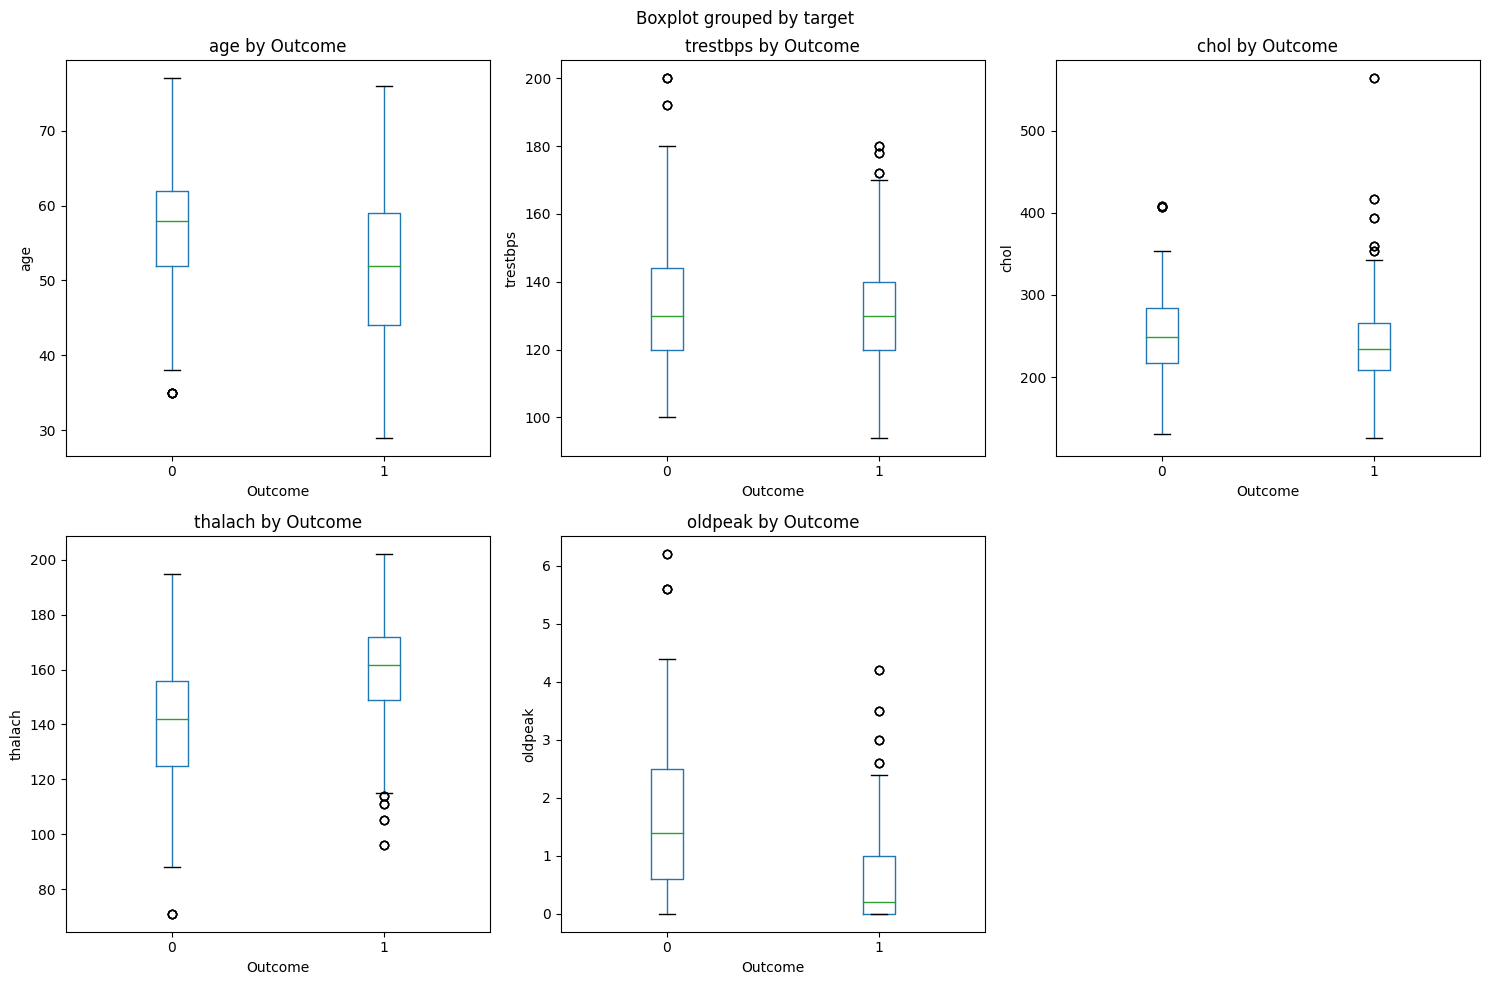

In [9]:
boxplot_grouping_by_cathegorical(heart_df, numerical,'target')

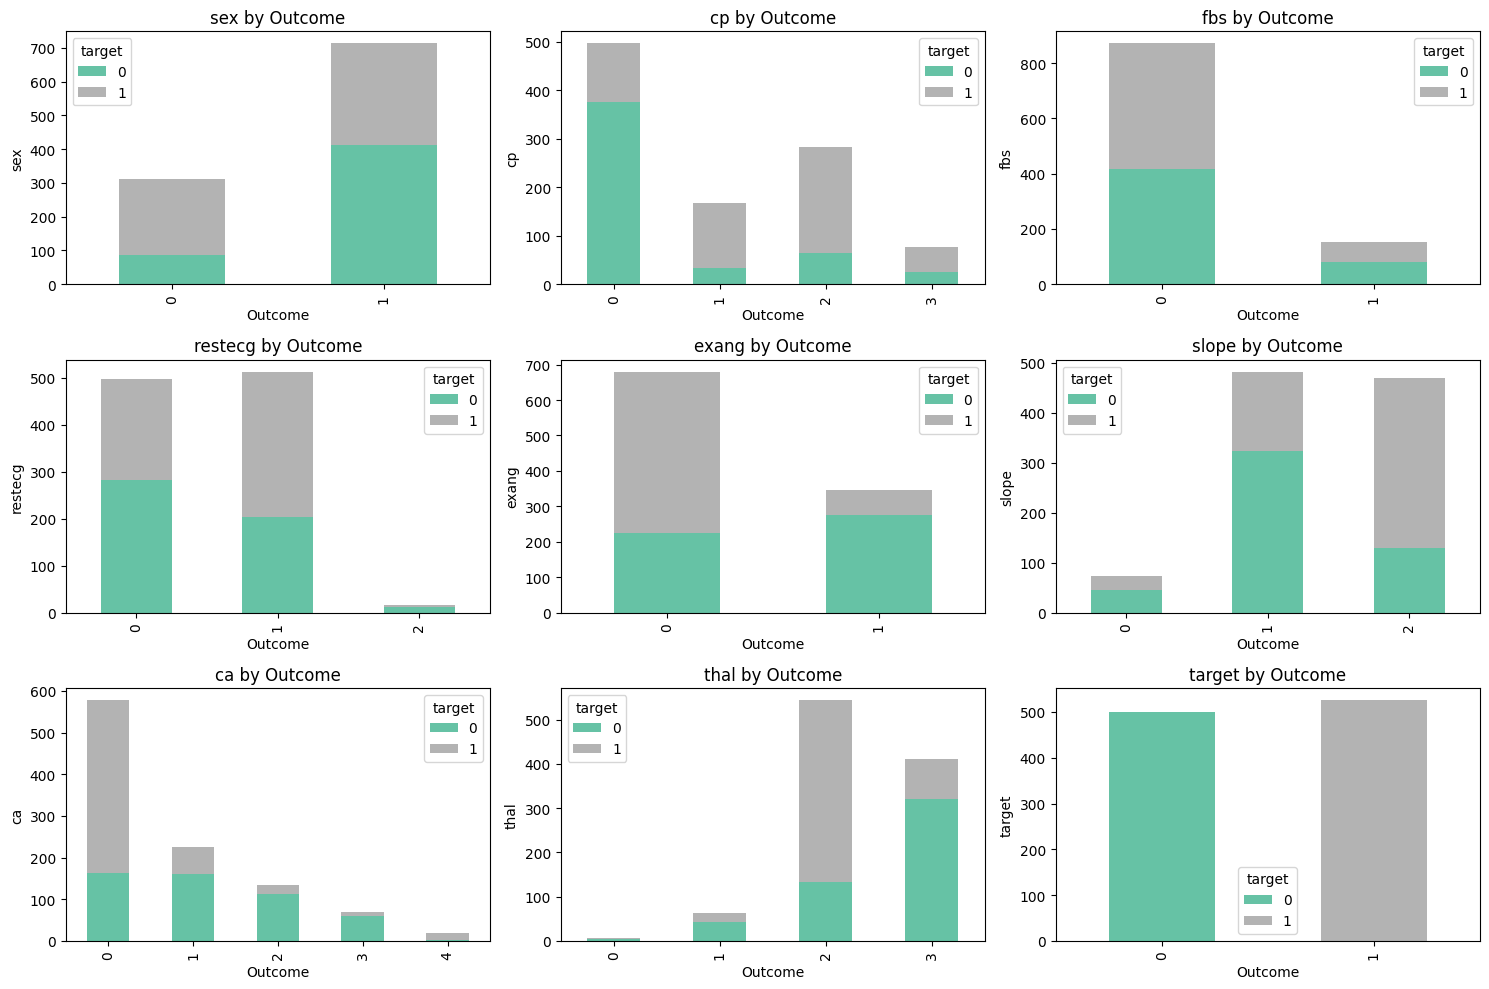

In [10]:
barplot_grouping_by_cathegorical(heart_df, categorical,'target')

Heatmap de correlaciones

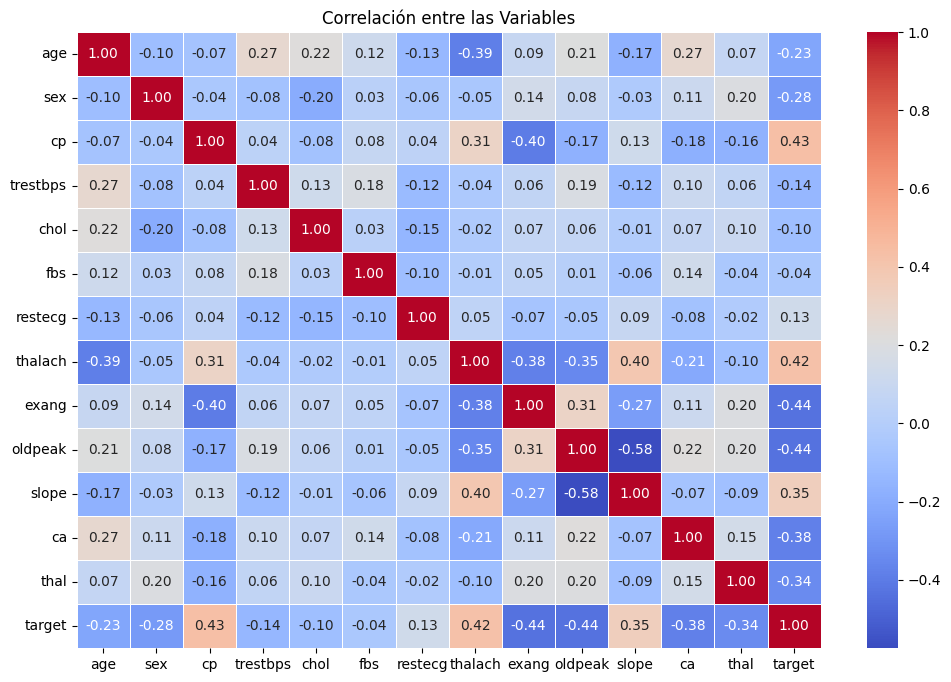

In [11]:
plot_correlation_heatmap(heart_df)

## DEFINIMOS EL OBJETIVO/MÉTRICA DEL PROBLEMA

Vamos a intentar maximizar el recall. 

In [12]:
categorical.remove('target')
X = heart_df[numerical+categorical]
y = heart_df['target']

## FEATURE IMPORTANCE

Aplicamos MDI y MDA.

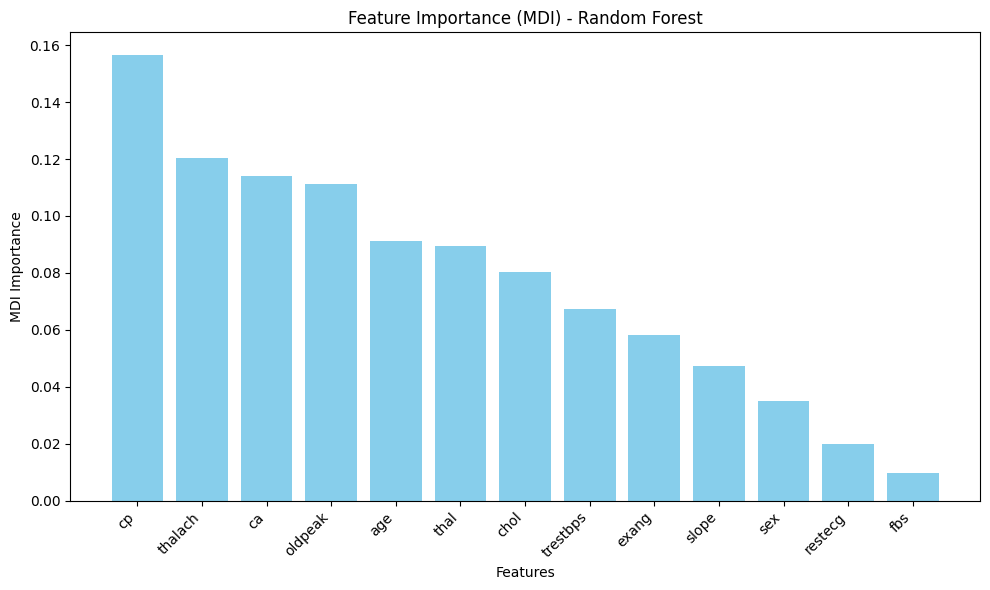

In [13]:
mdi(X,y)

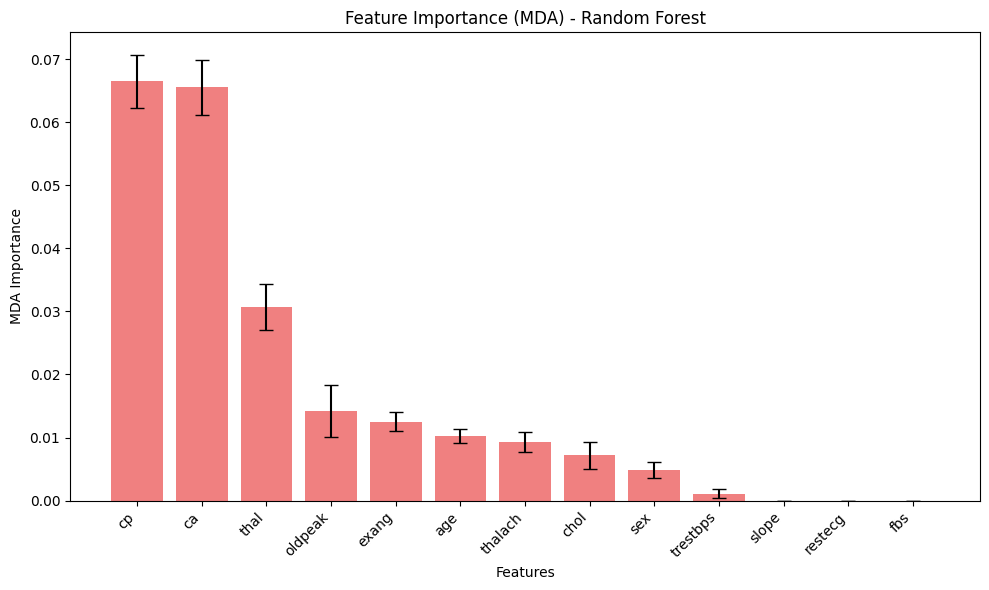

In [14]:
mda(X,y)

# DECISIÓN DE SI UTILIZAR TRAIN Y TEST O CROSS VALIDATION

Separamos el conjunto en train y test, vamos a dejar entre 20 y 30% de los datos para test. Utilizaremos random_state=42

Una vez se haya hecho el modelo de benchmark, modicaremos el random_state y volveremos a probar el modelo de benchmark. En caso de que los resultados cambien mucho se optará por usar cross validation. 



In [15]:
# División 80/20 inicial
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verificar el balance de clases en Train y Test
print("Distribución de Clases en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución de Clases en Test:\n", y_test.value_counts(normalize=True))

Distribución de Clases en Train:
 1    0.515854
0    0.484146
Name: target, dtype: float64

Distribución de Clases en Test:
 1    0.502439
0    0.497561
Name: target, dtype: float64


In [16]:
# Lista de random states
random_states = [1, 10, 42, 99, 123]
results = []

for rs in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)
    
    model = SVC(kernel="linear", probability=True, random_state=rs)  # Usamos SVM con Kernel Lineal
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results.append((rs, accuracy))

# Convertir resultados a DataFrame para visualizar
df_results = pd.DataFrame(results, columns=['Random State', 'Accuracy'])
print(df_results)



   Random State  Accuracy
0             1  0.819512
1            10  0.843902
2            42  0.804878
3            99  0.858537
4           123  0.878049


# MODELO DE BENCHMARK

Realizamos un modelo con todas las variables, sin transformar, a no ser que sea necesario transformarlas porque el modelo no funcione con las variables como están ahora.

In [17]:
# Dividir en Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar modelo Benchmark SVM
model = SVC(kernel="linear", probability=True, random_state=42)

# Entrenar modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilidad para la clase 1

# Evaluación del Modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Mostrar resultados
print(f"Benchmark Model Results (SVM, Kernel=Linear, rs=42)")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}\n")

print("Confusion Matrix:")
print(pd.DataFrame(conf_matrix, index=['No Disease', 'Disease'], columns=['Pred No', 'Pred Yes']))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Benchmark Model Results (SVM, Kernel=Linear, rs=42)
Accuracy: 0.8049
Precision: 0.7561
Recall: 0.9029
ROC-AUC: 0.8711

Confusion Matrix:
            Pred No  Pred Yes
No Disease       72        30
Disease          10        93

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.71      0.78       102
           1       0.76      0.90      0.82       103

    accuracy                           0.80       205
   macro avg       0.82      0.80      0.80       205
weighted avg       0.82      0.80      0.80       205



In [18]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix

# Definir Cross-Validation con 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo SVM con estandarización
model_svm_cv = SVC(kernel="linear", probability=True, random_state=42)

# Obtener predicciones en Cross-Validation
y_pred_cv = cross_val_predict(model_svm_cv, X, y, cv=cv)

# Evaluar el rendimiento del modelo basado en Cross-Validation
accuracy_cv = accuracy_score(y, y_pred_cv)
precision_cv = precision_score(y, y_pred_cv)
recall_cv = recall_score(y, y_pred_cv)
roc_auc_cv = roc_auc_score(y, y_pred_cv)

# Mostrar resultados
print(f"📊 Cross-Validation Predictions Results (SVM, 5-Fold)")
print(f"Accuracy: {accuracy_cv:.4f}")
print(f"Precision: {precision_cv:.4f}")
print(f"Recall: {recall_cv:.4f}")
print(f"ROC-AUC: {roc_auc_cv:.4f}\n")

# Mostrar Matriz de Confusión y Classification Report
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y, y_pred_cv), index=['No Disease', 'Disease'], columns=['Pred No', 'Pred Yes']))

print("\nClassification Report:")
print(classification_report(y, y_pred_cv))


📊 Cross-Validation Predictions Results (SVM, 5-Fold)
Accuracy: 0.8439
Precision: 0.8050
Recall: 0.9183
ROC-AUC: 0.8419

Confusion Matrix:
            Pred No  Pred Yes
No Disease      382       117
Disease          43       483

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       499
           1       0.81      0.92      0.86       526

    accuracy                           0.84      1025
   macro avg       0.85      0.84      0.84      1025
weighted avg       0.85      0.84      0.84      1025



# BALANCEO DE CARGA 

vamos a utilizar el parámetro class_weight="balanced"

In [19]:
# Definir Cross-Validation con 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo SVM con balanceo de clases
model_svm_balanced = SVC(kernel="linear", probability=True, random_state=42, class_weight="balanced")

# Obtener predicciones en Cross-Validation
y_pred_cv_balanced = cross_val_predict(model_svm_balanced, X, y, cv=cv)

# Evaluar el rendimiento del modelo basado en Cross-Validation con balanceo
accuracy_cv_balanced = accuracy_score(y, y_pred_cv_balanced)
precision_cv_balanced = precision_score(y, y_pred_cv_balanced)
recall_cv_balanced = recall_score(y, y_pred_cv_balanced)
roc_auc_cv_balanced = roc_auc_score(y, y_pred_cv_balanced)

# Mostrar resultados
print(f"📊 Cross-Validation Predictions Results (SVM, 5-Fold, class_weight='balanced')")
print(f"Accuracy: {accuracy_cv_balanced:.4f}")
print(f"Precision: {precision_cv_balanced:.4f}")
print(f"Recall: {recall_cv_balanced:.4f}")
print(f"ROC-AUC: {roc_auc_cv_balanced:.4f}\n")

# Mostrar Matriz de Confusión y Classification Report
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y, y_pred_cv_balanced), index=['No Disease', 'Disease'], columns=['Pred No', 'Pred Yes']))

print("\nClassification Report:")
print(classification_report(y, y_pred_cv_balanced))


📊 Cross-Validation Predictions Results (SVM, 5-Fold, class_weight='balanced')
Accuracy: 0.8468
Precision: 0.8080
Recall: 0.9202
ROC-AUC: 0.8448

Confusion Matrix:
            Pred No  Pred Yes
No Disease      384       115
Disease          42       484

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83       499
           1       0.81      0.92      0.86       526

    accuracy                           0.85      1025
   macro avg       0.85      0.84      0.85      1025
weighted avg       0.85      0.85      0.85      1025



# ESTANDARIZACIÓN DE VARIABLES CONTINUAS

Estandarizamos las variables continuas y probamos el modelo con las variables estandarizadas.

In [20]:
from sklearn.preprocessing import StandardScaler
# Variables continuas a estandarizar
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Aplicar StandardScaler
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[numerical] = scaler.fit_transform(X[numerical])

# Definir Cross-Validation con 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modelo SVM con balanceo de clases y estandarización
model_svm_scaled = SVC(kernel="linear", probability=True, random_state=42, class_weight="balanced")

# Obtener predicciones en Cross-Validation
y_pred_cv_scaled = cross_val_predict(model_svm_scaled, X_scaled, y, cv=cv)

# Evaluar el rendimiento del modelo con balanceo + estandarización
accuracy_cv_scaled = accuracy_score(y, y_pred_cv_scaled)
precision_cv_scaled = precision_score(y, y_pred_cv_scaled)
recall_cv_scaled = recall_score(y, y_pred_cv_scaled)
roc_auc_cv_scaled = roc_auc_score(y, y_pred_cv_scaled)

# Mostrar resultados
print(f"📊 Cross-Validation Predictions Results (SVM, 5-Fold, class_weight='balanced', Standardized Features)")
print(f"Accuracy: {accuracy_cv_scaled:.4f}")
print(f"Precision: {precision_cv_scaled:.4f}")
print(f"Recall: {recall_cv_scaled:.4f}")
print(f"ROC-AUC: {roc_auc_cv_scaled:.4f}\n")

# Mostrar Matriz de Confusión y Classification Report
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y, y_pred_cv_scaled), index=['No Disease', 'Disease'], columns=['Pred No', 'Pred Yes']))

print("\nClassification Report:")
print(classification_report(y, y_pred_cv_scaled))

📊 Cross-Validation Predictions Results (SVM, 5-Fold, class_weight='balanced', Standardized Features)
Accuracy: 0.8527
Precision: 0.8183
Recall: 0.9163
ROC-AUC: 0.8510

Confusion Matrix:
            Pred No  Pred Yes
No Disease      392       107
Disease          44       482

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84       499
           1       0.82      0.92      0.86       526

    accuracy                           0.85      1025
   macro avg       0.86      0.85      0.85      1025
weighted avg       0.86      0.85      0.85      1025



# FEATURE SELECTION



## Probamos a hacer forward y backward feature selection.



In [21]:
# Modelo base SVM con balanceo de clases
svm_model_fs = SVC(kernel="linear", probability=True, random_state=42, class_weight="balanced")

# Forward Selection
sfs_forward = SequentialFeatureSelector(svm_model_fs, n_features_to_select="auto", direction="forward", cv=5)
sfs_forward.fit(X_scaled, y)

# Backward Selection
sfs_backward = SequentialFeatureSelector(svm_model_fs, n_features_to_select="auto", direction="backward", cv=5)
sfs_backward.fit(X_scaled, y)

# Obtener las features seleccionadas
selected_features_forward = X_scaled.columns[sfs_forward.get_support()]
selected_features_backward = X_scaled.columns[sfs_backward.get_support()]

# Mostrar resultados
print(f"📌 Features Seleccionadas con Forward Selection: {list(selected_features_forward)}")
print(f"📌 Features Seleccionadas con Backward Selection: {list(selected_features_backward)}")


📌 Features Seleccionadas con Forward Selection: ['thalach', 'oldpeak', 'sex', 'cp', 'ca', 'thal']
📌 Features Seleccionadas con Backward Selection: ['thalach', 'oldpeak', 'sex', 'cp', 'restecg', 'ca', 'thal']


## Por otra parte probamos a entrenar el modelo solo con las variables que destacan mucho en mdi y mda, en caso de que las haya.

In [22]:
# Definir Cross-Validation con 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función para entrenar y evaluar SVM con diferentes conjuntos de variables
def train_svm_with_features(X, selected_features, feature_set_name):
    # Filtrar solo las variables seleccionadas
    X_subset = X[selected_features].copy()

    # Identificar qué variables dentro del conjunto son numéricas
    numerical_subset = [col for col in selected_features if col in ['thalach', 'oldpeak', 'age', 'chol']]
    
    # Estandarizar solo las variables numéricas presentes en este conjunto
    if numerical_subset:
        scaler = StandardScaler()
        X_subset[numerical_subset] = scaler.fit_transform(X_subset[numerical_subset])

    # Modelo SVM con balanceo de clases
    model_svm = SVC(kernel="linear", probability=True, random_state=42, class_weight="balanced")

    # Obtener predicciones con Cross-Validation
    y_pred_cv = cross_val_predict(model_svm, X_subset, y, cv=cv)

    # Evaluación del modelo
    accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv)
    recall = recall_score(y, y_pred_cv)
    roc_auc = roc_auc_score(y, y_pred_cv)

    print(f"\n📊 Cross-Validation Results for {feature_set_name} (Standardized)")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    print("\nConfusion Matrix:")
    print(pd.DataFrame(confusion_matrix(y, y_pred_cv), index=['No Disease', 'Disease'], columns=['Pred No', 'Pred Yes']))

    print("\nClassification Report:")
    print(classification_report(y, y_pred_cv))

In [23]:
features_forward = ['thalach', 'oldpeak', 'sex', 'cp', 'ca', 'thal']
train_svm_with_features(X, features_forward, "Forward Selection Features")


📊 Cross-Validation Results for Forward Selection Features (Standardized)
Accuracy: 0.8371
Precision: 0.8270
Recall: 0.8631
ROC-AUC: 0.8364

Confusion Matrix:
            Pred No  Pred Yes
No Disease      404        95
Disease          72       454

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       499
           1       0.83      0.86      0.84       526

    accuracy                           0.84      1025
   macro avg       0.84      0.84      0.84      1025
weighted avg       0.84      0.84      0.84      1025



In [24]:
features_backward = ['thalach', 'oldpeak', 'sex', 'cp', 'restecg', 'ca', 'thal']
train_svm_with_features(X, features_backward, "Backward Selection Features")



📊 Cross-Validation Results for Backward Selection Features (Standardized)
Accuracy: 0.8361
Precision: 0.8196
Recall: 0.8726
ROC-AUC: 0.8351

Confusion Matrix:
            Pred No  Pred Yes
No Disease      398       101
Disease          67       459

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       499
           1       0.82      0.87      0.85       526

    accuracy                           0.84      1025
   macro avg       0.84      0.84      0.84      1025
weighted avg       0.84      0.84      0.84      1025



In [25]:
features_mdi_mda = ['cp', 'thalach', 'ca', 'oldpeak', 'age', 'thal', 'chol']
train_svm_with_features(X, features_mdi_mda, "MDI & MDA Features")



📊 Cross-Validation Results for MDI & MDA Features (Standardized)
Accuracy: 0.8107
Precision: 0.7814
Recall: 0.8764
ROC-AUC: 0.8090

Confusion Matrix:
            Pred No  Pred Yes
No Disease      370       129
Disease          65       461

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       499
           1       0.78      0.88      0.83       526

    accuracy                           0.81      1025
   macro avg       0.82      0.81      0.81      1025
weighted avg       0.82      0.81      0.81      1025



# HACEMOS GRID SEARCH 

Se realiza la búsqueda de hiper parámetros óptima.

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Definir Cross-Validation con 5 folds estratificados
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables seleccionadas por Forward Selection
features_forward = ['thalach', 'oldpeak', 'sex', 'cp', 'ca', 'thal']

# Estandarizar solo las variables numéricas
numerical = ['thalach', 'oldpeak']
scaler = StandardScaler()
X_forward = X[features_forward].copy()
X_forward[numerical] = scaler.fit_transform(X_forward[numerical])

# Configurar estudio Optuna con TPESampler para optimización más rápida
study = optuna.create_study(direction="maximize", sampler=TPESampler())

# Función objetivo con Cross-Validation
def objective(trial):
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)  # Escala logarítmica corregida
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"])

    # Si el kernel es "linear", gamma no se usa
    if kernel == "linear":
        gamma = "scale"
    else:
        gamma = trial.suggest_float("gamma", 1e-3, 1e1, log=True)  # Escala logarítmica corregida

    # Inicializar modelo con los hiperparámetros sugeridos
    model = SVC(C=C, kernel=kernel, gamma=gamma, probability=True, class_weight="balanced", random_state=42)

    # Obtener predicciones en Cross-Validation
    y_pred_cv = cross_val_predict(model, X_forward, y, cv=cv, n_jobs=-1)  # Paralelismo en predicción

    # Evaluar métricas
    accuracy = accuracy_score(y, y_pred_cv)

    return accuracy  # Optuna maximiza la Accuracy en CV

# Ejecutar Optuna con Paralelismo
study.optimize(objective, n_trials=50, n_jobs=-1, show_progress_bar=True)  # Paralelismo activado

# Obtener los mejores hiperparámetros
best_params = study.best_params
print(f"\n📊 Mejores Hiperparámetros con Optuna (Paralelismo activado):")
print(best_params)
print(f"Mejor Accuracy en CV: {study.best_value:.4f}")


[I 2025-01-27 20:06:52,308] A new study created in memory with name: no-name-f94e49de-5039-4a5a-b6b2-99876d24b19c


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-01-27 20:06:52,950] Trial 6 finished with value: 0.8263414634146341 and parameters: {'C': 0.006044068108583465, 'kernel': 'linear'}. Best is trial 6 with value: 0.8263414634146341.
[I 2025-01-27 20:06:53,751] Trial 1 finished with value: 0.9873170731707317 and parameters: {'C': 74.66276178482906, 'kernel': 'rbf', 'gamma': 1.3292414761009068}. Best is trial 1 with value: 0.9873170731707317.
[I 2025-01-27 20:06:53,882] Trial 7 finished with value: 0.9014634146341464 and parameters: {'C': 76.23922943344888, 'kernel': 'rbf', 'gamma': 0.09262978518557621}. Best is trial 1 with value: 0.9873170731707317.
[I 2025-01-27 20:06:53,964] Trial 0 finished with value: 0.864390243902439 and parameters: {'C': 65.70881404087056, 'kernel': 'rbf', 'gamma': 0.024879416152073383}. Best is trial 1 with value: 0.9873170731707317.
[I 2025-01-27 20:06:54,046] Trial 5 finished with value: 0.8526829268292683 and parameters: {'C': 0.9287199859599435, 'kernel': 'poly', 'gamma': 0.1556487376388452}. Best is

In [ ]:
# Entrenar modelo final con los mejores hiperparámetros
best_model = SVC(**best_params, probability=True, class_weight="balanced", random_state=42)
y_pred_final = cross_val_predict(best_model, X_forward, y, cv=cv)

# Evaluación del modelo optimizado
accuracy_final = accuracy_score(y, y_pred_final)
precision_final = precision_score(y, y_pred_final)
recall_final = recall_score(y, y_pred_final)
roc_auc_final = roc_auc_score(y, y_pred_final)

# Mostrar resultados finales
print(f"\n📊 Resultados Finales del Modelo Optimizado con Optuna:")
print(f"Accuracy: {accuracy_final:.4f}")
print(f"Precision: {precision_final:.4f}")
print(f"Recall: {recall_final:.4f}")
print(f"ROC-AUC: {roc_auc_final:.4f}")

print("\nConfusion Matrix:")
print(pd.DataFrame(confusion_matrix(y, y_pred_final), index=['No Disease', 'Disease'], columns=['Pred No', 'Pred Yes']))

print("\nClassification Report:")
print(classification_report(y, y_pred_final))